In [1]:
import torch
import random
import numpy as np
from collections import deque
from snake import SnakeGame, Direction, Point
from model import Linear_QNet, Conv_QNet, ConvQTrainer, QTrainer
from helper import plot

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

In [3]:
class Agent:
    def __init__(self, network="linear"):
        self.curr_step = 0
        self.epsilon = 0 # randomness
        self.gamma = 0.9 # discount rate
        self.memory = deque(maxlen=MAX_MEMORY) # popleft()
        self.network = network
        self.exploration_rate = 1
        self.exploration_rate_decay = 0.99999975
        self.exploration_rate_min = 0.1

        if network == "convolutional":
            self.model = Conv_QNet(24, 24, 3)
            self.trainer = ConvQTrainer(self.model, lr=LR, gamma=self.gamma)
        else:
            self.model = Linear_QNet(11, 256, 3)
            self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)


    def get_state(self, game):
        if self.network == "convolutional":
            return(game.getStack()/255 - 0.5)/0.5
            
        else:
            head = game.snake[0]
            point_l = Point(head.x - 20, head.y)
            point_r = Point(head.x + 20, head.y)
            point_u = Point(head.x, head.y - 20)
            point_d = Point(head.x, head.y + 20)
            
            dir_l = game.direction == Direction.LEFT
            dir_r = game.direction == Direction.RIGHT
            dir_u = game.direction == Direction.UP
            dir_d = game.direction == Direction.DOWN

            state = [
                # Danger straight
                (dir_r and game.is_collision(point_r)) or 
                (dir_l and game.is_collision(point_l)) or 
                (dir_u and game.is_collision(point_u)) or 
                (dir_d and game.is_collision(point_d)),

                # Danger right
                (dir_u and game.is_collision(point_r)) or 
                (dir_d and game.is_collision(point_l)) or 
                (dir_l and game.is_collision(point_u)) or 
                (dir_r and game.is_collision(point_d)),

                # Danger left
                (dir_d and game.is_collision(point_r)) or 
                (dir_u and game.is_collision(point_l)) or 
                (dir_r and game.is_collision(point_u)) or 
                (dir_l and game.is_collision(point_d)),
                
                # Move direction
                dir_l,
                dir_r,
                dir_u,
                dir_d,
                
                # Food location 
                game.food.x < game.head.x,  # food left
                game.food.x > game.head.x,  # food right
                game.food.y < game.head.y,  # food up
                game.food.y > game.head.y  # food down
                ]

            return np.array(state, dtype=int)

 

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)
        #for state, action, reward, nexrt_state, done in mini_sample:
        #    self.trainer.train_step(state, action, reward, next_state, done)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        final_move = [0,0,0]
        if np.random.rand() < self.exploration_rate:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            print(move)
            final_move[move] = 1
        
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
        self.curr_step += 1

        return final_move

In [4]:
def train(mode = "linear"):
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = Agent(mode)
    game = SnakeGame()
    n_iterations = 300
    i = 1
    while i < n_iterations:
        # get old state
        state_old = agent.get_state(game)

        # get move
        final_move = agent.get_action(state_old)

        # perform move and get new state
        reward, done, score = game.play_step(final_move)
        state_new = agent.get_state(game)

        # train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        # remember
        agent.remember(state_old, final_move, reward, state_new, done)

        if done:
            # train long memory, plot result
            i += 1
            game.reset()
            agent.train_long_memory()

            if score > record:
                record = score
                agent.model.save()

            print('Game', i, 'Score', score, 'Record:', record)

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / i
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores)


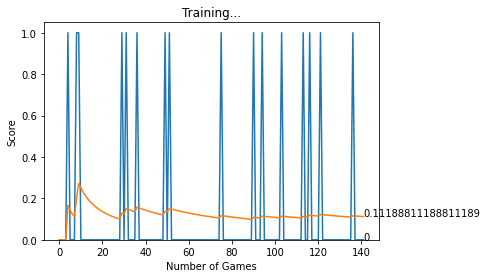

0
1


NameError: name 'quit' is not defined

In [5]:
train("convolutional")

In [ ]:
train("linear")